## 0. Описание ноутбука

   В данном ноутбуке приводится обработка тестового (скачанного с Kaggle) и тренировочного (полученного после парсинга сайта auto.ru) датасетов.
    
   В результате выполнения этого ноутбука получен датаесет, подготовленный для обучения моделей.
    
   Минимальная предварительная предобработка, а так-же код парсинга представлены в "предыдущем" ноутбуке, который сохранен в этом-же репозитории.


## 1. Импорт библиотек и настройка параметров

Подключим необходимые бибилиотеки, пропишем пути для файловых операций и зададим системные параметры.

In [120]:
# Импортируем библиотеки:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import os
import re
from datetime import datetime
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

%matplotlib inline

In [2]:
# Увеличиваем число отображаемых строк и столбцов в pandas:

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [3]:
# Задаем дирректорию для работы с файлами:

# При выполнении на kaggle раскомментировать этот блок:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
# PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# При выполнении локально раскомментировать этот блок:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = './data/'

./data/cars_dicts.txt
./data/.DS_Store
./data/not_read_links.txt
./data/car_links.txt
./data/test.csv
./data/train.csv
./data/test_finished.csv
./data/pages_count_list.txt
./data/sample_submission.csv


## 2. Загрузка тренировочного и тестового датасетов

Загружаем датасеты, подготовленные в результате работы "прошлого" ноутбука.

### 2.1 Загрузка данных

In [4]:
# Загрузим наш предобаботанный тестовый датасет:

test = pd.read_csv(PATH_to_file + 'test_finished.csv')

print('Размер тестового датасета: ', test.shape)
display(test.sample(5))

Размер тестового датасета:  (34686, 21)


,body_type,brand,color,description,engine_volume,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,owners_count,ownership,docs,drive,steering
10847,седан,BMW,чёрный,Птс оригинал. 13 год. Первый хозяин- дилер. До...,3.0 LTR,313 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",дизель,172000,2012,7ER,4,1603120714,2013,автоматическая,EUROPEAN,3,NaN,Оригинал,полный,Левый
7907,внедорожник 5 дв.,BMW,синий,Чистокровный Американец 2008 года рождения! На...,4.8 LTR,355 N12,NaN,бензин,256000,2006,X5,5,1603109056,2008,автоматическая,EUROPEAN,3,NaN,Оригинал,полный,Левый
23428,внедорожник 5 дв.,VOLKSWAGEN,чёрный,Артикул: 25355\n\nПРИ ПОКУПКЕ АВТОМОБИЛЯ В КРЕ...,2.0 LTR,170 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,107000,2011,TIGUAN,5,1603213717,2013,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый
489,хэтчбек 5 дв.,SKODA,серебристый,При покупке автомобиля:\n► Возможна покупка ав...,1.6 LTR,105 N12,"{""condition"":true,""abs"":true,""ptf"":true,""elect...",бензин,239064,2007,FABIA,5,1603228156,2010,автоматическая,EUROPEAN,2,NaN,Оригинал,передний,Левый
2274,лифтбек,SKODA,чёрный,"Авто полностью обслужен, стоит ГБО официально ...",1.6 LTR,102 N12,"{""gbo"":true}",бензин,224000,2000,OCTAVIA,5,1603234794,2006,механическая,EUROPEAN,2,33.0,Оригинал,передний,Левый


In [5]:
# Загрузим наш предобаботанный тренировочный датасет:

train = pd.read_csv(PATH_to_file + 'train.csv')

print('Размер тестового датасета: ', train.shape)
display(train.sample(5))

Размер тестового датасета:  (92003, 21)


,body_type,brand,color,description,engine_volume,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,owners_count,docs,drive,steering,price
59975,внедорожник 5 дв.,RENAULT,бежевый,.\n\n-Продажа автомобилей с пробегом.\n-Выкуп ...,1.5 LTR,86 N12,"{'tinted-glass': True, 'steel-wheels': True, '...",дизель,147000,2010,DUSTER,5,1631307514,2013,механическая,EUROPEAN,3,ORIGINAL,FORWARD_CONTROL,LEFT,540000
30469,внедорожник 5 дв.,LAND_ROVER,чёрный,Ваш выбор и Ваше время — наши главные приорите...,4.4 LTR,339 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",дизель,89000,2012,RANGE_ROVER,5,1631235949,2016,автоматическая,EUROPEAN,2,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,5710000
69215,седан,BMW,красный,Отличное внешнее и техническое состояние. Ком...,3.0 LTR,234 N12,{},бензин,147000,2008,3ER,4,1631328685,2010,автоматическая,EUROPEAN,4,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,760000
10493,внедорожник 5 дв.,MITSUBISHI,белый,Покупал у официального дилера Mitsubishi. Обсл...,3.5 LTR,186 N12,"{'engine-proof': True, 'cruise-control': True,...",бензин,195000,2008,PAJERO_SPORT,5,1631187427,2011,автоматическая,JAPANESE,2,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1270000
49709,хэтчбек 5 дв.,TOYOTA,белый,отличный авто японской сборки Toyota allex в х...,1.4 LTR,97 N12,{},бензин,222000,2003,COROLLA,5,1631282018,2004,механическая,JAPANESE,1,DUPLICATE,FORWARD_CONTROL,RIGHT,430000


### 2.1 "Синхронизация" датасетов

In [6]:
# Наши датасеты хоть и похожи, но не совсем идентичны, перед началом EDA необходимо убедиться,
# что данные в них хранятся в одинаковых форматах.

display(test.info())

display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   body_type         34686 non-null  object 
 1   brand             34686 non-null  object 
 2   color             34686 non-null  object 
 3   description       34686 non-null  object 
 4   engine_volume     34686 non-null  object 
 5   engine_power      34686 non-null  object 
 6   equipment         24690 non-null  object 
 7   fuel_type         34686 non-null  object 
 8   mileage           34686 non-null  int64  
 9   model_date        34686 non-null  int64  
 10  model_name        34686 non-null  object 
 11  doors_num         34686 non-null  int64  
 12  parsing_unixtime  34686 non-null  int64  
 13  production_date   34686 non-null  int64  
 14  transmission      34686 non-null  object 
 15  vendor            34686 non-null  object 
 16  owners_count      34686 non-null  int64 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92003 entries, 0 to 92002
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   body_type         92003 non-null  object
 1   brand             92003 non-null  object
 2   color             92003 non-null  object
 3   description       92003 non-null  object
 4   engine_volume     92003 non-null  object
 5   engine_power      92003 non-null  object
 6   equipment         92003 non-null  object
 7   fuel_type         92003 non-null  object
 8   mileage           92003 non-null  int64 
 9   model_date        92003 non-null  int64 
 10  model_name        92003 non-null  object
 11  doors_num         92003 non-null  int64 
 12  parsing_unixtime  92003 non-null  int64 
 13  production_date   92003 non-null  int64 
 14  transmission      92003 non-null  object
 15  vendor            92003 non-null  object
 16  owners_count      92003 non-null  int64 
 17  docs        

None

In [7]:
# Названия колонок и их типы (кроме колонок ownership и price) совпадают.
# Теперь посмотрим на кол-во. значений в них:

display(train.nunique().sort_values())

display(test.nunique().sort_values())

docs                    2
steering                2
drive                   3
doors_num               4
owners_count            4
transmission            4
vendor                  4
fuel_type               5
color                  16
body_type              24
brand                  24
engine_volume          57
model_date             71
production_date        71
engine_power          384
mileage               767
model_name            910
price                1323
equipment           58922
description         86266
parsing_unixtime    91936
dtype: int64

steering                2
docs                    2
vendor                  2
owners_count            3
drive                   3
transmission            4
fuel_type               5
doors_num               5
brand                  12
color                  16
body_type              24
engine_volume          55
model_date             66
production_date        69
ownership             244
engine_power          315
model_name            544
mileage             11268
equipment           23705
description         31732
parsing_unixtime    34686
dtype: int64

In [8]:
# Из тестового датасета удаляем колонку ownership, которая не спарсилась в тренировочном:

test.drop(columns='ownership', inplace=True)

#### 2.1.1 Бинарные признаки

In [9]:
# Начнем с Бинарных переменных. Посмотрим как они закодированы в обоих датасетах:

bin_cols = ['steering', 'docs', 'vendor']

print('----- Тестовый датасет -----')
for col in bin_cols:
    print(f'Значения в колнке {col}: {test[col].unique()}')
    
print('----- Тренировочный датасет -----')
for col in bin_cols:
    print(f'Значения в колнке {col}: {train[col].unique()}')

----- Тестовый датасет -----
Значения в колнке steering: ['Левый' 'Правый']
Значения в колнке docs: ['Оригинал' 'Дубликат']
Значения в колнке vendor: ['EUROPEAN' 'JAPANESE']
----- Тренировочный датасет -----
Значения в колнке steering: ['LEFT' 'RIGHT']
Значения в колнке docs: ['ORIGINAL' 'DUPLICATE']
Значения в колнке vendor: ['EUROPEAN' 'JAPANESE' 'RUSSIAN' 'AMERICAN']


In [10]:
# Кодировка значений в колонках steering и docs не совпадает. 
# Приведем ее к единому варианту (латинскими буквами): 

test.steering = test.steering.apply(lambda x: 'LEFT' if x == 'Левый' else 'RIGHT')
test.docs = test.docs.apply(lambda x: 'ORIGINAL' if x == 'Оригинал' else 'DUPLICATE')

In [11]:
# В тренировочный датасет попали записи с не японскими или европейскими вендорами.
# Посмотрим их:

display(train[train.vendor == 'RUSSIAN'])

display(train[train.vendor == 'AMERICAN'])

,body_type,brand,color,description,engine_volume,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,owners_count,docs,drive,steering,price
1808,внедорожник 5 дв.,SUZUKI,зелёный,двигатель масло не ест коробка хтс раздатка хт...,1.6 LTR,97 N12,{},бензин,212000,1988,SIDEKICK,5,1631165488,1992,механическая,RUSSIAN,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,250000
33712,внедорожник 5 дв.,SUZUKI,чёрный,"На ходу, сигнализация ЦЗ. Кондиционер ГУР,магн...",1.6 LTR,97 N12,"{'condition': True, 'wheel-power': True, 'alar...",бензин,281000,1988,SIDEKICK,5,1631243349,1995,автоматическая,RUSSIAN,4,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,210000
63150,внедорожник 5 дв.,SUZUKI,серый,"Машина в отличном состоянии.\nНичего не гудит,...",2.0 LTR,136 N12,{},бензин,222000,1988,SIDEKICK,5,1631315021,1995,автоматическая,RUSSIAN,2,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,230000
64924,внедорожник 5 дв.,SUZUKI,чёрный,"Автoмобиль нaходится в pазобраннoм сoстoянии, ...",1.6 LTR,97 N12,{},бензин,175000,1988,SIDEKICK,5,1631319085,1995,автоматическая,RUSSIAN,4,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,130000
75468,внедорожник 5 дв.,SUZUKI,серый,"Автoмобиль 92 гoдa выпускa, кузов подустал,год...",2.0 LTR,136 N12,{},бензин,428000,1988,SIDEKICK,5,1631342828,1992,механическая,RUSSIAN,4,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,180000
87849,внедорожник 5 дв.,SUZUKI,серый,"Продам авто, 1.6/ 97л.с. акпп, все вопросы по ...",2.0 LTR,136 N12,{'gbo': True},бензин,129000,1988,SIDEKICK,5,1631371777,1996,автоматическая,RUSSIAN,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,220000


,body_type,brand,color,description,engine_volume,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,owners_count,docs,drive,steering,price
70803,минивэн,VOLKSWAGEN,пурпурный,Всем привет. Продаю мощный авто 201 л.с. двига...,2.8 LTR,201 N12,"{'cruise-control': True, 'tinted-glass': True,...",бензин,312000,1997,EUROVAN,4,1631332158,2001,автоматическая,AMERICAN,4,ORIGINAL,FORWARD_CONTROL,LEFT,750000
89099,минивэн,VOLKSWAGEN,красный,Авто с реальным пробегом! Завезён из сша владе...,2.8 LTR,140 N12,{},бензин,348000,1997,EUROVAN,4,1631374622,2001,автоматическая,AMERICAN,1,ORIGINAL,FORWARD_CONTROL,LEFT,700000


In [12]:
# Значения 'RUSSIAN' и 'AMERICAN' присвоены по ошибке: все "русские" машины это 
# SUZUKI, т.е. "японцы", а "американские" это "VOLKSWAGEN", т.е. "европейцы".
# Исправим это:

train.vendor = train.vendor.apply(lambda x: 'EUROPEAN' if x == 'AMERICAN' else x)
train.vendor = train.vendor.apply(lambda x: 'JAPANESE' if x == 'RUSSIAN' else x)

display(train.vendor.unique())

array(['EUROPEAN', 'JAPANESE'], dtype=object)

#### 2.1.2 Категориальные переменные (drive, owners_count, transmission, fuel_type, doors_num)

In [13]:
cat_cols = ['drive', 'owners_count', 'transmission', 'fuel_type', 'doors_num']

print('----- Тестовый датасет -----')
for col in cat_cols:
    print(f'Значения в колнке {col}: {test[col].unique()}')
    
print('----- Тренировочный датасет -----')
for col in cat_cols:
    print(f'Значения в колнке {col}: {train[col].unique()}')

----- Тестовый датасет -----
Значения в колнке drive: ['передний' 'полный' 'задний']
Значения в колнке owners_count: [3 1 2]
Значения в колнке transmission: ['роботизированная' 'механическая' 'автоматическая' 'вариатор']
Значения в колнке fuel_type: ['бензин' 'дизель' 'гибрид' 'электро' 'газ']
Значения в колнке doors_num: [5 4 2 3 0]
----- Тренировочный датасет -----
Значения в колнке drive: ['ALL_WHEEL_DRIVE' 'FORWARD_CONTROL' 'REAR_DRIVE']
Значения в колнке owners_count: [1 2 4 3]
Значения в колнке transmission: ['автоматическая' 'роботизированная' 'механическая' 'вариатор']
Значения в колнке fuel_type: ['дизель' 'бензин' 'гибрид' 'электро' 'газ']
Значения в колнке doors_num: [5 4 2 3]


In [14]:
# Расхождения наблюдаются в колонках drive и doors_num. Кроме того в  колонке owners_count 
# тренировочного датасета больше вариантов значний (в тестовом датасете 3 означает 3 и более).
# Исправим это:

train.owners_count = train.owners_count.apply(lambda x: x if x < 3 else 3)

drive_dict = {'передний' : 'FORWARD_CONTROL', 
              'полный' : 'ALL_WHEEL_DRIVE',
              'задний' : 'REAR_DRIVE'}

test.drive = test.drive.apply(lambda x: drive_dict[x])

In [15]:
# Посмотрим что за машины в тестовом датасете имеют 0 дверей:

display(test[test.doors_num == 0])

,body_type,brand,color,description,engine_volume,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,owners_count,docs,drive,steering
16944,кабриолет,MERCEDES,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32 N12,NaN,бензин,48000,1904,SIMPLEX,0,1603245843,1904,механическая,EUROPEAN,1,ORIGINAL,REAR_DRIVE,RIGHT


In [16]:
# Один единственный автомобиль, да еще и супер-раритетный (1904 год!). По оисанию и изображениям
# в интернете у него действительно нет дверей, но конструктивно это что-то среднее между седаном и
# кабриолетом. Отнесем его у купе (т.е. 2 двери), как более редкому типу:

test.doors_num = test.doors_num.apply(lambda x: 2 if x == 0 else x)

#### 2.1.2 parsing_unixtime

In [17]:
# До объединения датасета поработаем с признаком parsing_unixtime. Очевидно, что для модели
# он бесполезен: если парсить данные в другом порядке или в другой, не слишком отдаленный день,
# то время меняется, а остальные данные нет. Но, т.к. между парсингом тестового и тренировочного
# датасетов прошло значительное время, средний уровень цен автомобилей мог изменится. Надо посмотреть
# в какое время парсились тестовые объявления и после предсказания моделью цены сделать 
# корректировку (на изменение курса доллара или по данным росстата, решим позднее).
# Извлекаем информацию о среднем, максимальном и минимальном времени парсинга в датасетах:

test_time = datetime.fromtimestamp(test.parsing_unixtime.mean())
train_time = datetime.fromtimestamp(train.parsing_unixtime.mean())

print(f'Среднее время парсинга в тренировочном датасете: {train_time.strftime("%d %B %Y")}')
print(f'Среднее время парсинга в тестовом датасете: {test_time.strftime("%d %B %Y")}')

Среднее время парсинга в тренировочном датасете: 10 September 2021
Среднее время парсинга в тестовом датасете: 21 October 2020


In [18]:
# Итак, между парсингом датасетов прошло больше года. При подготовке submission надо
# не забыть внести соответствующую поправку. Теперь колонки parsing_unixtime можно
# удалить в обоих датасетах:

test.drop(columns='parsing_unixtime', inplace=True)
train.drop(columns='parsing_unixtime', inplace=True)

#### 2.1.2 equipment

In [19]:
# В тестовом датасете в столбце equipment присутствуют пропуски. Т.к. equipment
# это по сути словарь с опциями (пока, для удобства, сохраненный как строковая переменная),
# то пропуски можно заполнить "пустыми словарями":

test.equipment = test.equipment.fillna('{}')

### 2.2 Объединение датасетов

In [20]:
# Теперь подготовимм наши датасеты к объединению. К тестотовому датасету
# добавим пустую колонку price:

test['price'] = np.nan

In [21]:
# Добавим столбец test. У тестового датасета значение будет 1, у тренировочного 0:

test['test'] = 1
train['test'] = 0

In [22]:
# Теперь объединим датасеты:

df = pd.concat([test, train], ignore_index = True)

display(df.shape)

display(df.sample(10))

(126689, 21)

,body_type,brand,color,description,engine_volume,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,production_date,transmission,vendor,owners_count,docs,drive,steering,price,test
80012,седан,OPEL,серебристый,На ходу. Идеальна для первой машины. Звёзд с н...,1.8 LTR,116 N12,"{'alloy-wheel-disks': True, 'tinted-glass': Tr...",бензин,357000,1998,ASTRA,4,2004,автоматическая,EUROPEAN,3,ORIGINAL,FORWARD_CONTROL,LEFT,210000.0,0
51996,внедорожник 5 дв.,TOYOTA,красный,Продается хороший семейный автомобиль в родной...,3.3 LTR,212 N12,"{'keyless-entry': True, 'alarm': True}",гибрид,185000,2010,HIGHLANDER,5,2011,вариатор,JAPANESE,2,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,2020000.0,0
123040,лифтбек,SKODA,белый,"Продаёт собственник. Не бит не крашен, не такс...",2.0 LTR,184 N12,"{'engine-proof': True, 'esp': True, 'airbag-dr...",дизель,49000,2017,OCTAVIA,5,2018,роботизированная,EUROPEAN,1,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1520000.0,0
90716,хэтчбек 5 дв.,NISSAN,серый,",\nАСЦ / ЧЕСТНО, Автомобили с пробегом.\nМы го...",1.6 LTR,110 N12,"{'asr': True, 'airbag-driver': True, 'isofix':...",бензин,142000,2010,TIIDA,5,2012,механическая,JAPANESE,2,ORIGINAL,FORWARD_CONTROL,LEFT,670000.0,0
36051,лифтбек,RENAULT,серый,"В автомобиле много чего поменял, звоните все р...",2.0 LTR,140 N12,"{'cruise-control': True, 'alloy-wheel-disks': ...",бензин,478000,2001,LAGUNA,5,2001,механическая,EUROPEAN,3,ORIGINAL,FORWARD_CONTROL,LEFT,250000.0,0
20400,внедорожник 5 дв.,TOYOTA,чёрный,"\n\nВыпуск июль 2007 г, второй...",4.2 LTR,204 N12,{},дизель,256000,2005,LAND_CRUISER,5,2007,автоматическая,JAPANESE,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,NaN,1
55953,внедорожник 5 дв.,LAND_ROVER,чёрный,«Оками. Автомобили с пробегом» - Ваш надежный ...,2.2 LTR,150 N12,"{'cruise-control': True, 'engine-proof': True,...",дизель,91000,2012,FREELANDER,5,2014,механическая,EUROPEAN,1,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1610000.0,0
89575,седан,VOLKSWAGEN,чёрный,Мы работаем для вас и с удовольствием вам помо...,1.8 LTR,152 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,103000,2011,PASSAT,4,2013,роботизированная,EUROPEAN,3,ORIGINAL,FORWARD_CONTROL,LEFT,1340000.0,0
76148,седан,MERCEDES,белый,"Автомобиль 2019г.в., с покупки в одной семье. ...",2.0 LTR,245 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",дизель,29000,2016,E_KLASSE,4,2019,автоматическая,EUROPEAN,1,ORIGINAL,REAR_DRIVE,LEFT,3470000.0,0
63039,внедорожник 5 дв.,BMW,белый,🌚Ночь продаж в РОЛЬФ Алтуфьево!🌚\n\n💵Только 9 ...,2.0 LTR,150 N12,"{'cruise-control': True, 'esp': True, 'usb': T...",дизель,158000,2014,X3,5,2017,автоматическая,EUROPEAN,2,ORIGINAL,REAR_DRIVE,LEFT,2000000.0,0


## 3. Обработка общего датасета

Теперь можно перейти к EDA.

### 3.1 Предобработка данных

In [23]:
# Посмотрим информацию по объединенному датасету:

display(df.info())

display(df.nunique().sort_values())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126689 entries, 0 to 126688
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   body_type        126689 non-null  object 
 1   brand            126689 non-null  object 
 2   color            126689 non-null  object 
 3   description      126689 non-null  object 
 4   engine_volume    126689 non-null  object 
 5   engine_power     126689 non-null  object 
 6   equipment        126689 non-null  object 
 7   fuel_type        126689 non-null  object 
 8   mileage          126689 non-null  int64  
 9   model_date       126689 non-null  int64  
 10  model_name       126689 non-null  object 
 11  doors_num        126689 non-null  int64  
 12  production_date  126689 non-null  int64  
 13  transmission     126689 non-null  object 
 14  vendor           126689 non-null  object 
 15  owners_count     126689 non-null  int64  
 16  docs             126689 non-null  obje

None

test                    2
steering                2
docs                    2
vendor                  2
drive                   3
owners_count            3
transmission            4
doors_num               4
fuel_type               5
color                  16
brand                  24
body_type              25
engine_volume          58
model_date             74
production_date        75
engine_power          389
model_name            936
price                1323
mileage             11506
equipment           82627
description        117498
dtype: int64

In [24]:
# Посмотрим как закодированы данные в бинарных и категориальных признаках:

bin_cat = bin_cols
bin_cat.extend(cat_cols)

for col in bin_cat:
    print(f'Значения в колнке {col}: {df[col].unique()}')

Значения в колнке steering: ['LEFT' 'RIGHT']
Значения в колнке docs: ['ORIGINAL' 'DUPLICATE']
Значения в колнке vendor: ['EUROPEAN' 'JAPANESE']
Значения в колнке drive: ['FORWARD_CONTROL' 'ALL_WHEEL_DRIVE' 'REAR_DRIVE']
Значения в колнке owners_count: [3 1 2]
Значения в колнке transmission: ['роботизированная' 'механическая' 'автоматическая' 'вариатор']
Значения в колнке fuel_type: ['бензин' 'дизель' 'гибрид' 'электро' 'газ']
Значения в колнке doors_num: [5 4 2 3]


In [25]:
# Значения в колонках transmission и fuel_type написаны по руски.
# Пересохраним их по английски:

transmission_dict = {'роботизированная' : 'robotic', 
                      'механическая' : 'mechanical',
                      'автоматическая' : 'automatic',
                      'вариатор' : 'variator'}

fuel_dict = {'бензин' : 'gasoline', 
             'дизель' : 'diesel',
             'гибрид' : 'hybrid',
             'электро' : 'electro',
             'газ' : 'gas'}

df.transmission = df.transmission.apply(lambda x: transmission_dict[x])
df.fuel_type = df.fuel_type.apply(lambda x: fuel_dict[x])

In [26]:
# А так-же пересохраним признаки, записанные заглавными буквами, строчными буквами:

for col in ['brand', 'model_name', 'vendor', 'docs', 'drive', 'steering']:
    df[col] = df[col].apply(lambda x: x.lower())

In [27]:
# Можно сразу преобразовать признак с объемом двигателя в числовой. Опытным путем я выяснил что в
# датасете у некоторых записей отсутствует число (вероятно это электромобили), им поставим объем 0.0:

df.engine_volume = df.engine_volume.apply(lambda x: '0.0' if x == ' LTR' 
                                              else x.split()[0]).astype('float')

In [28]:
# Так-же сразу преобразуем столбец engine_power в числовой:

df.engine_power = df.engine_power.apply(lambda x: x.split()[0]).astype('int')

### 3.2 "Большие" категориальные признаки

Сначала обработаем признаки которые имеют много разных значений, но, фактически, являются категориальными.

#### 3.2.1 body_type

In [29]:
# Посмотрим на признак body_type:

df.body_type.value_counts()

внедорожник 5 дв.          45167
седан                      44153
хэтчбек 5 дв.              11312
лифтбек                     6280
универсал 5 дв.             5444
компактвэн                  3171
минивэн                     3092
хэтчбек 3 дв.               2357
купе                        2306
пикап двойная кабина         917
фургон                       629
внедорожник 3 дв.            594
купе-хардтоп                 350
кабриолет                    284
родстер                      268
седан-хардтоп                138
микровэн                     130
пикап одинарная кабина        23
седан 2 дв.                   22
пикап полуторная кабина       21
внедорожник открытый          12
тарга                          8
лимузин                        8
универсал 3 дв.                2
фастбек                        1
Name: body_type, dtype: int64

In [30]:
# У нас присутствует слишком много "лишних" вариантов (например внедорожников и пикапов по 3 штуки),
# которые неплохо было-бы объединить:

df.body_type.replace(regex={r'внедорожник.*': 'внедорожник', r'седан.*': 'седан',
                            r'хэтчбек.*': 'хэтчбек', r'купе.*': 'купе',
                            r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                            r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                            r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                            r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                            r'лимузин.*': 'лимузин', r'фургон.*': 'фургон',
                            r'кабриолет.*': 'кабриолет'}, inplace=True)

In [31]:
# Наименее "популярные" типы кузова (микровэн, лимузин, тарга и фастбек) можно считать выбросами.
# Объединим их все в общий тип "другое":

rare_body_types = ['микровэн', 'лимузин', 'тарга', 'фастбек']

df.body_type = df.body_type.apply(lambda x: 'другое' if x in rare_body_types else x)

In [32]:
# Посмотрим сколько осталось типов кузова:

display(len(df.body_type.unique()))

13

In [33]:
# Количество различных вариантов сократилось с 25 до 13 (почти в 2 раза), 
# самые редкие типы кузова сгруппированы в общий тип "другое". 

#### 3.2.2 color

In [34]:
# Посмотрим на признак color:

display(df.color.value_counts())

чёрный         34776
белый          25572
серый          16684
серебристый    14825
синий          11832
красный         6406
коричневый      5114
зелёный         3663
бежевый         2399
голубой         1658
золотистый       904
пурпурный        860
фиолетовый       740
жёлтый           656
оранжевый        542
розовый           58
Name: color, dtype: int64

In [35]:
# У нас присутствуют как очень популярные цвета (черный, белый и т.д.), так и
# редкие (самый редкий розовый). Объединять цвета не будем, т.к. даже "розовый" 
# сложно считать выбросом (все-таки в нашем датсете более полусотни машин такого цвета). 
# Вместо объединения разных цветов, лучше сгенерируем новый бинарный признак 
# популярности цвета. Составим список популярных цветов:

popular_colours = []

pop_colour_value = df.color.value_counts().describe()['mean']

for i in range(len(df.color.value_counts())):
    if df.color.value_counts().iloc[i] >= pop_colour_value:
        popular_colours.append(df.color.value_counts().index[i])

In [36]:
# Теперь добавим бинарный столбец pop_colour, показывающий популярность цвета авто:

df['pop_color'] = df.color.apply(lambda x: 1 if x in popular_colours else 0)

#### 3.2.3 brand

In [37]:
# Посмотрим на признак brand:

display(df.brand.value_counts())

toyota        15197
nissan        13322
volkswagen    13136
bmw           11751
mercedes      11601
audi           8455
mitsubishi     8408
skoda          7032
renault        5938
opel           4552
honda          4044
mazda          3879
volvo          3431
lexus          2972
peugeot        2190
land_rover     2048
infiniti       1921
subaru         1385
suzuki         1361
citroen        1322
porsche        1195
datsun          730
fiat            470
mini            349
Name: brand, dtype: int64

In [38]:
# Даже самый редкий бренд 'mini' представлен в нашем датасете почти 350 автомобилями.
# Можно сгенерировать сразу 2 новых бинарных признака, первый это популярность бренда
# (как мы сделали с цветом авто), второй элитность бренда (которая почти наверняка 
# оказывает влияние на цену автомобиля). Сначала займемся популярностью бренда:

popular_brands = []

pop_brand_value = df.brand.value_counts().describe()['mean']

for i in range(len(df.brand.value_counts())):
    if df.brand.value_counts().iloc[i] >= pop_brand_value:
        popular_brands.append(df.brand.value_counts().index[i])

In [39]:
# Добавим бинарный столбец pop_brand, показывающий популярность бренда авто:

df['pop_brand'] = df.brand.apply(lambda x: 1 if x in popular_brands else 0)

In [40]:
# Теперь составим список элитных марок авто и сгенерируем признак элитности бренда:

elite_brands = ['bmw', 'mercedes', 'audi', 'lexus', 'infiniti', 'porsche']

df['elite_brand'] = df.brand.apply(lambda x: 1 if x in elite_brands else 0)

#### 3.2.4 model_name

In [41]:
# В нашем датасете очень много моделей авто, многие из которых представлены
# в одном или нескольких экземплярах:

df.model_name.value_counts()

octavia    3427
5er        2701
polo       2624
camry      2458
passat     2220
           ... 
m1            1
502           1
1200          1
adam          1
eqv           1
Name: model_name, Length: 936, dtype: int64

In [42]:
# В нашем датасете присутсвует множество "уникальных" моеделей авто. Сначала я хотел
# всех их объединить в одну категорию, но, т.к. сочетание марки и модели авто является
# важным "признаком" само по себе, решил этого не делать. Все-таки даже для 
# "уникальных" автомобилей нам надо уметь предсказывать цену. Вместо этого можно
# сгенерировать новый бинарный признак популярности модели авто по аналогии с брендом
# и цветом, но (т.к. моделей авто гораздо больше) границей возьмем 75% персентиль:

popular_models = []

pop_model_value = df.model_name.value_counts().describe()['75%']

for i in range(len(df.model_name.value_counts())):
    if df.model_name.value_counts().iloc[i] >= pop_model_value:
        popular_models.append(df.model_name.value_counts().index[i])

In [43]:
df['pop_model'] = df.model_name.apply(lambda x: 1 if x in popular_models else 0)

### 3.3 Числовые переменные

In [44]:
# Составим список числовых переменных:

num_cols = ['engine_volume', 'engine_power', 'mileage',
            'model_date', 'production_date', 'price']

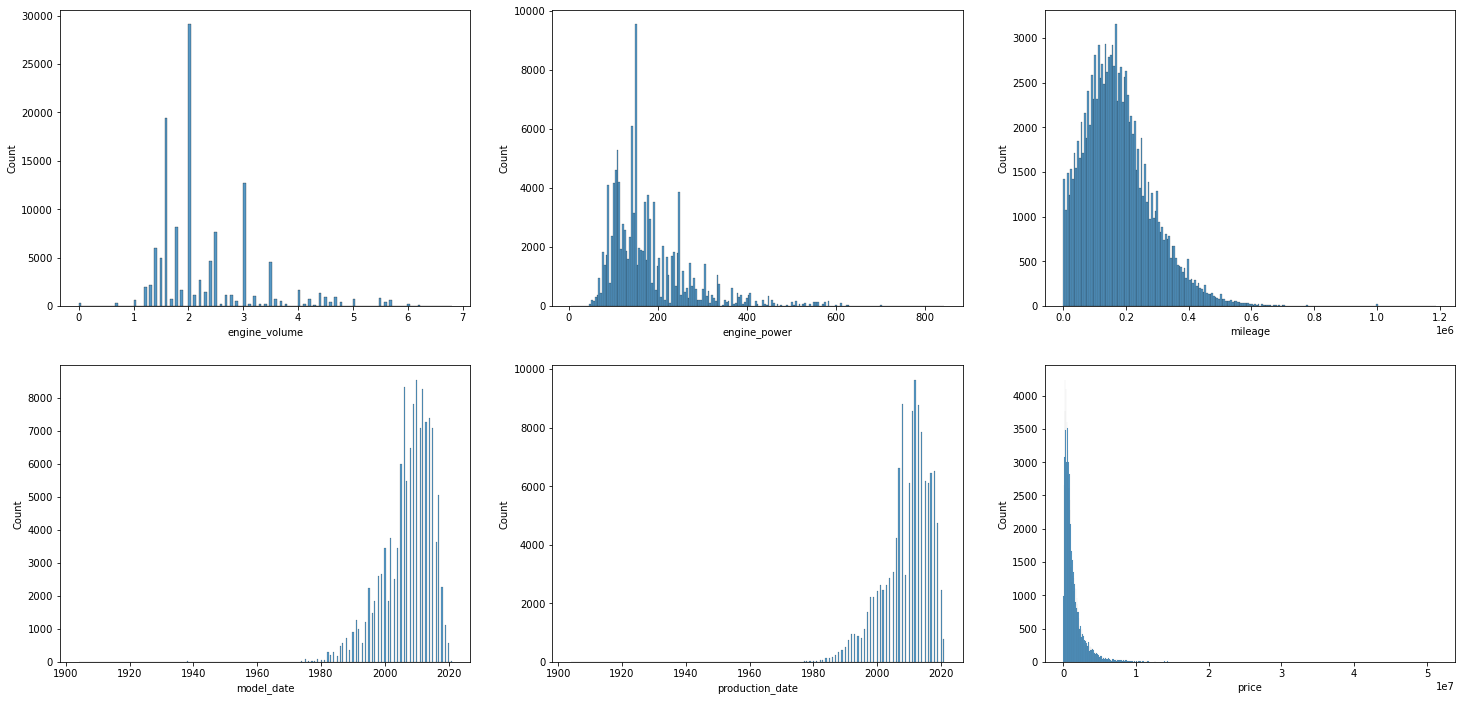

In [45]:
# Посмотрим на распределение числовых переменных:

fig, axes = plt.subplots(2, 3, figsize=(25, 12))
for col, i in zip(num_cols, range(6)):
    sns.histplot(df[col], kde=False, ax=axes.flat[i])

In [46]:
# По графикам видно что все переменные распределены с некоторым смещением: 
# engine_volume, engine_power и price смещены влево, а model_date и production_date
# вправо. Ничего удивительного в этом нет: чем старше авто, тем меньше шансов найти
# его "живым", а дешевых, маломощных авто с небольшим двигателем всегда больше.
# Распределение mileage почти нормальное, только "обрубленное" слева, т.к. пробега 
# меньше 0 быть не может.
# Сначала я хотел "обработать" выбросы с помощью межквартильных интервалов, но предварительное 
# моделирование не показало улучшений от этой процедуры. К тому-же наличие атомобилей с
# "нестандартными" параметрами это нормально, для машин с высоким пробегом или мощных
# спортивных автомобилей тоже надо уметь предсказывать цену.
# К тому-же самым "смещенным" признаком с наибольшими выбросами как раз является price, 
# т.е. наша целевая переменная.

<AxesSubplot:>

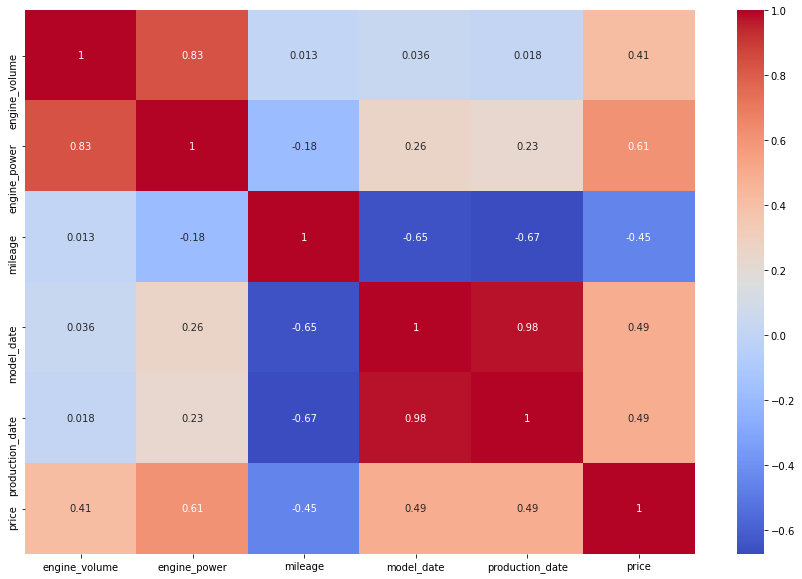

In [47]:
# Построим матрицу корреляций для числовых признаков:

plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')

In [48]:
# Видна очень сильная корреляция между годом представления и производства модели,
# что более чем логично. Один из признаков надо будет удалить, взамен можно добавить
# признак с разностью годов выпуска и анонса модели. 
# Так-же сильно скоррелированы мощность и объем двигателя (тоже логично, надо  
# подумать стоит-ли удалять какой-либо из признаков).
# Достаточно сильна корреляция между пробегом авто и годом выпуска/анонса, что
# легко объяснимо - более старые машины имеют бОльший пробег. Возможно, следует добавить
# признак пробег/возраст авто и удалить какой-то из существующих.
# Стоит подумать о добавлении категориального признака, зависящего от возраста авто.
# Корреляцию цены авто с любым из признаков тоже можно понять: более мощные и новые авто с
# меньшим пробегом, естественно, стоят дороже чем старые и маломощные.

#### 3.3.1 Генерация новых признаков на основе числовых переменных

In [49]:
# Сгенерируем числовой признак, который будет показывать разницу между годом 
# выпуска и годом анонса автомобиля:

df['prod_annot'] = df.production_date - df.model_date

display(df.prod_annot.value_counts())

 1     34170
 2     32055
 3     22665
 0     16054
 4     12241
 5      5378
 6      1954
 7       804
 8       549
 9       312
 10      166
 11       99
 12       58
 13       46
-1        38
-2        19
 15       18
 14       14
 22        9
 18        6
 16        6
 34        5
 17        3
 21        3
 23        3
 35        3
-3         2
 46        1
-4         1
-7         1
 20        1
 44        1
 40        1
 27        1
 19        1
 24        1
Name: prod_annot, dtype: int64

In [50]:
# Упс! Где-то в данных были ошибки, т.к. некоторые машины оказались "выпушены" еще до 
# своего анонса, а некоторые наоборот выпустили через десятки лет после анонса. Все "странные" 
# значения (меньше 0 и больше 15) будем считать выбросами и приравняем их всех к -1:

df.prod_annot = df.prod_annot.apply(lambda x: -1 if x not in range(0, 16) else x)

In [51]:
# Теперь удалим признак model_date:

df.drop(columns='model_date', inplace=True)

(0.0, 500000.0)

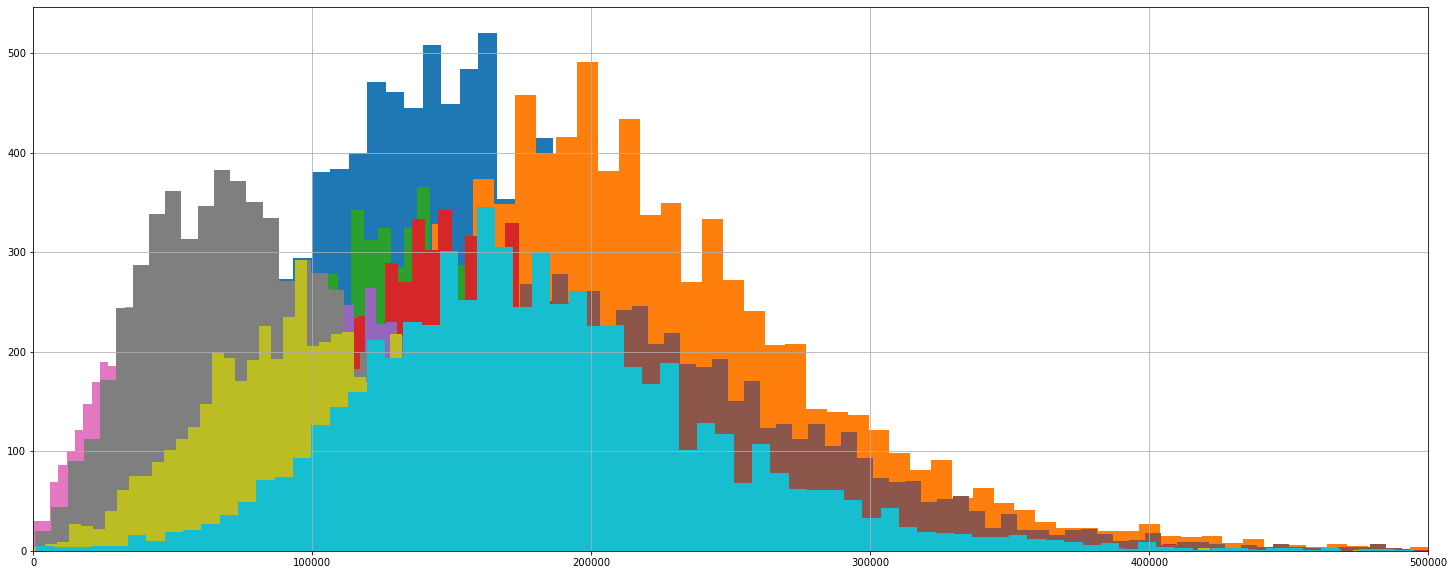

In [52]:
# Проверим распределение пробега зависит от года выпуска авто. Выведем графики
# для 10 самых популярных годов выпуска:

fig, ax = plt.subplots(figsize=(25, 10))

for x in (df.production_date.value_counts())[0:10].index:
    df[df.production_date == x].mileage.hist(bins=150)

ax.set_xlim(0, 500000)

In [53]:
# Как и предполагалось, распределение пробега более-менее нормальное если смотреть его по годам.
# Сгенерируем соответствующий признак. Напишем функцию, которая получив строку датфрейма
# выдает информацию о пробеге деленном на возраст авто:

def km_per_year(row):
    
    now = datetime.now().year
    
    if now - row['production_date'] == 0:
        return row['mileage']
    else:
        return round(row['mileage']/(now - row['production_date']))

In [54]:
# Применяем нашу функцию:

df['km_year'] = df.apply(km_per_year, axis=1)

<AxesSubplot:xlabel='km_year', ylabel='Count'>

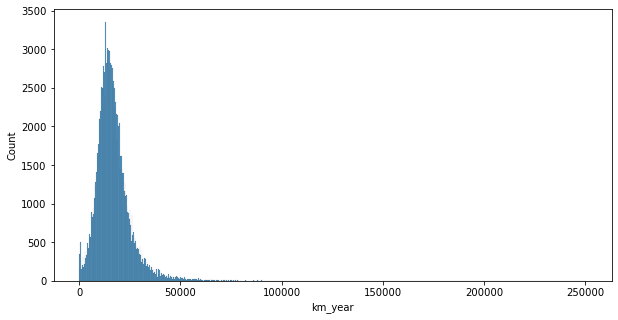

In [55]:
plt.rcParams['figure.figsize'] = 10, 5
sns.histplot(df.km_year, kde=False)

In [56]:
# Предполагалось, что распределение признака будет нормальном, но все-равно получился длинный 
# правый хвост. Пока оставим ризнак как есть, позже, возможно, прологарифмируем его.

In [57]:
# Добавим категориальный признак зависящий от возраста автомобиля. Будем использовать
# классификацию FIVA из википедии:

#Class A (Ancestor) — выпуска до 31 декабря 1904 года
#Class B (Veteran) — с 1 января 1905 по 31 декабря 1918
#Class C (Vintage) — с 1 января 1919 по 31 декабря 1930
#Class D (Post Vintage) — с 1 января 1931 по 31 декабря 1945
#Class E (Post War) — с 1 января 1946 по 31 декабря 1960
#Class F — с 1 января 1961 по 31 декабря 1970
#Class G — с 1 января 1971 и вплоть до минимального возраста, установленного FIVA — 30 лет.

# Напишем и применим функцию, которая по году выпуска авто будет возвращать его класс:

def rarity_class(prod_year):
    if prod_year <= 1904:
        return 'Class A'
    elif prod_year in range(1905, 1919):
        return 'Class B'
    elif prod_year in range(1919, 1931):
        return 'Class C'
    elif prod_year in range(1931, 1946):
        return 'Class D'
    elif prod_year in range(1946, 1961):
        return 'Class E'
    elif prod_year in range(1961, 1971):
        return 'Class F'
    elif prod_year in range(1971, (datetime.now().year - 29)):
        return 'Class G'
    else:
        return 'Not rare'
    
df['rarity'] = df.production_date.apply(rarity_class)

In [58]:
# Посмотрим что получилось:

df.rarity.value_counts()

Not rare    123652
Class G       2978
Class E         26
Class F         19
Class D         13
Class A          1
Name: rarity, dtype: int64

In [59]:
# Как и ожидалось раритетных автомобилей мало, а сильно раритетных совсем мало.
# Пока оставляем признак как есть, потом м.быть переведем его в бинарный.

In [60]:
# Составим обновленный список числовых переменных:

num_cols = ['engine_volume', 'engine_power', 'mileage',
            'production_date', 'price', 'prod_annot', 'km_year']

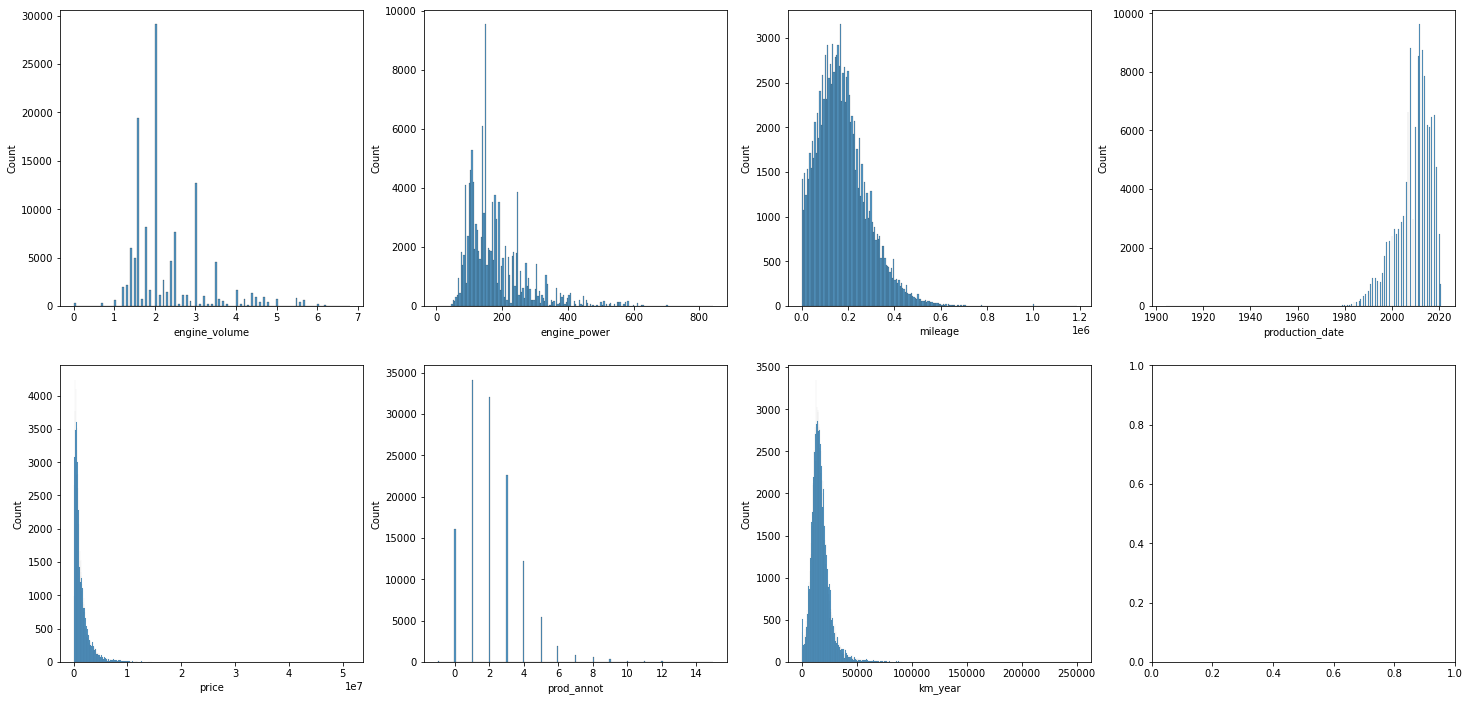

In [61]:
# Снова посмотрим на распределение числовых переменных:

fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(7)):
    sns.histplot(df[col], kde=False, ax=axes.flat[i])

<AxesSubplot:xlabel='price', ylabel='Count'>

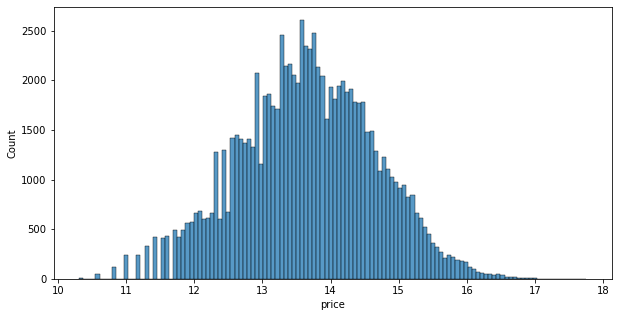

In [62]:
# Самое сильное смещение от нормального у нас наблюдается в целевой переменной price.
# Посмотрим что будет если ее логарифмировать:

sns.histplot(np.log(df['price']), kde=False)

In [63]:
# Видно что распределение становится почти нормальным. Прологарифмируем переменную, 
# а после, для получения "нормальных" данных, посчитаем экспоненту:

df.price = np.log(df['price'])

<AxesSubplot:>

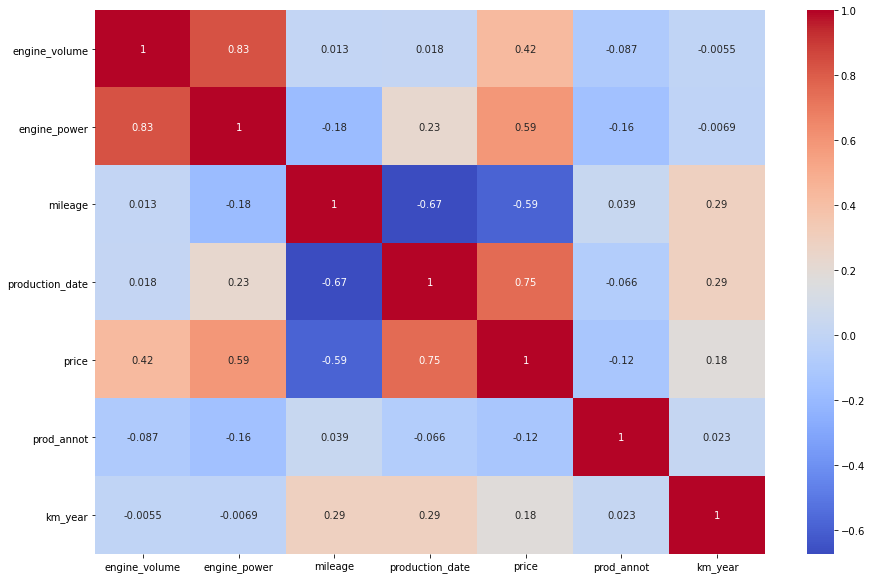

In [64]:
# Построим обновленную матрицу корреляций для числовых признаков:

plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')

<AxesSubplot:>

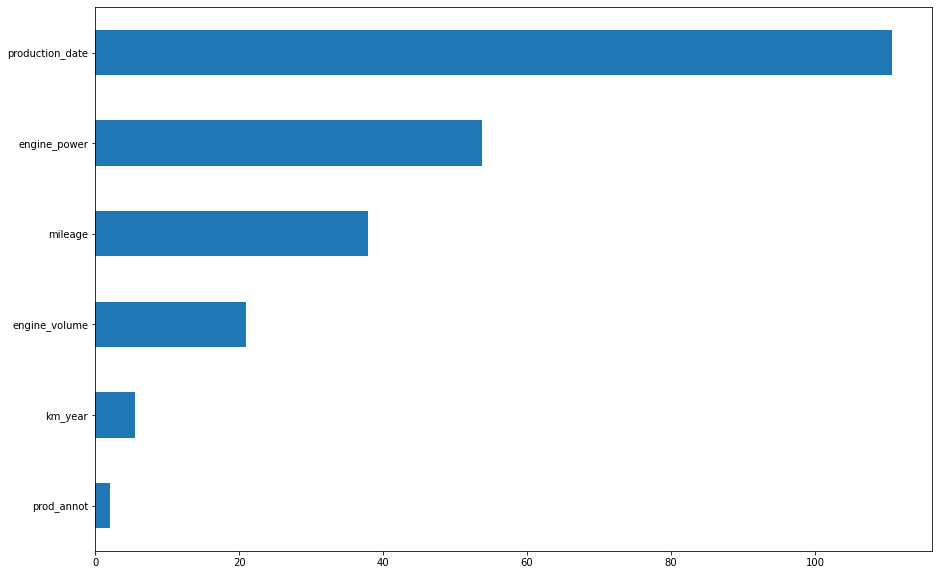

In [65]:
# Проверим значимость числовых переменных:

# Удаляем price из списка числовых переменных:
num_cols.remove('price')

imp_num = pd.Series(f_classif(df[df.test == 0][num_cols], 
                              df[df.test == 0].price)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [66]:
# Вывод: все оставшиеся числовые признаки значимы для модели, все оставляем.

### 3.3 Бинарные переменные

In [67]:
# Составим список бинарных переменных:

bin_cols = ['vendor', 'pop_model', 'elite_brand', 'pop_brand',
            'pop_color', 'steering', 'docs']

In [68]:
# Посмотрим как закодированы наши бинарные переменные:

for col in bin_cols:
    print(f'Значения в колнке {col}: {df[col].unique()}')

display(df[bin_cols].sample(5))

Значения в колнке vendor: ['european' 'japanese']
Значения в колнке pop_model: [1 0]
Значения в колнке elite_brand: [0 1]
Значения в колнке pop_brand: [1 0]
Значения в колнке pop_color: [1 0]
Значения в колнке steering: ['left' 'right']
Значения в колнке docs: ['original' 'duplicate']


,vendor,pop_model,elite_brand,pop_brand,pop_color,steering,docs
23044,japanese,1,1,0,0,left,original
121958,european,1,0,0,1,left,original
14620,japanese,1,0,1,0,left,original
7974,european,1,1,1,1,left,original
7365,european,1,0,0,0,left,original


In [69]:
# Преобразуем бинарные переменные в 0 и 1:

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

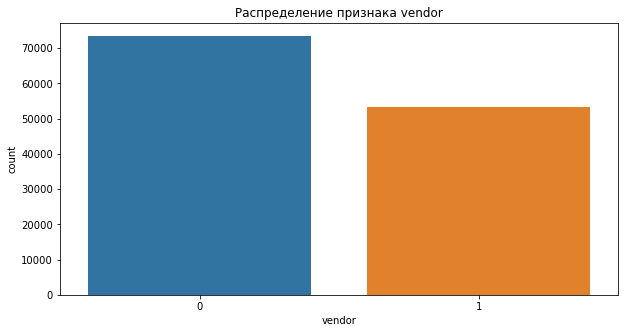

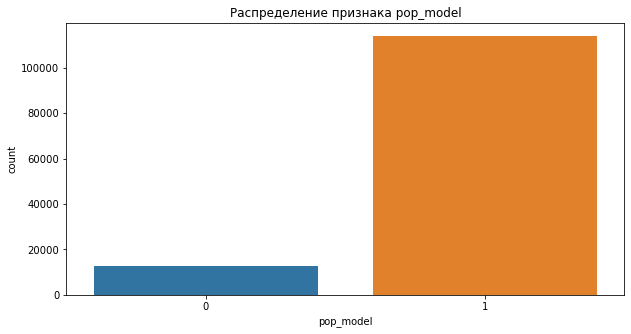

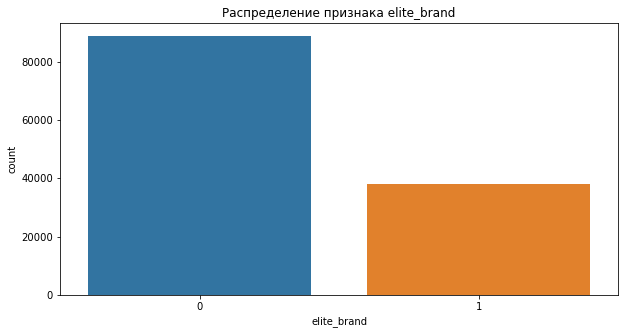

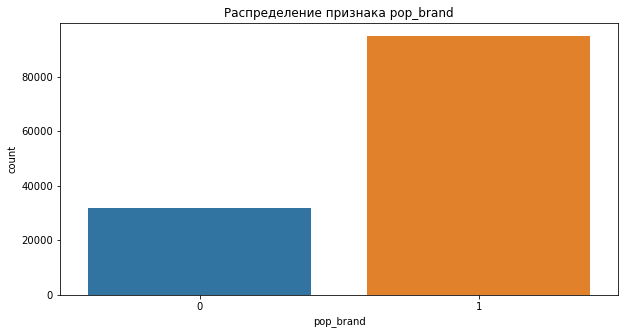

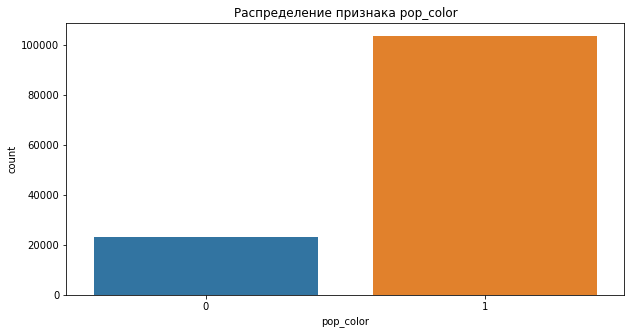

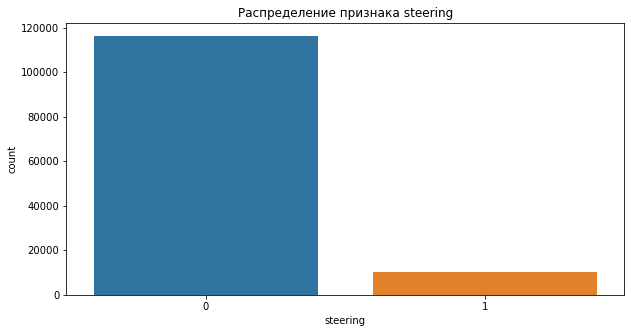

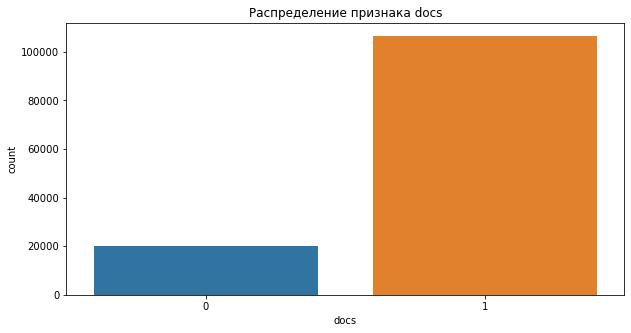

In [70]:
# Построим графики распределения бинарных переменных:

for col in bin_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=df)
    plt.title(f'Распределение признака {col}')

<AxesSubplot:>

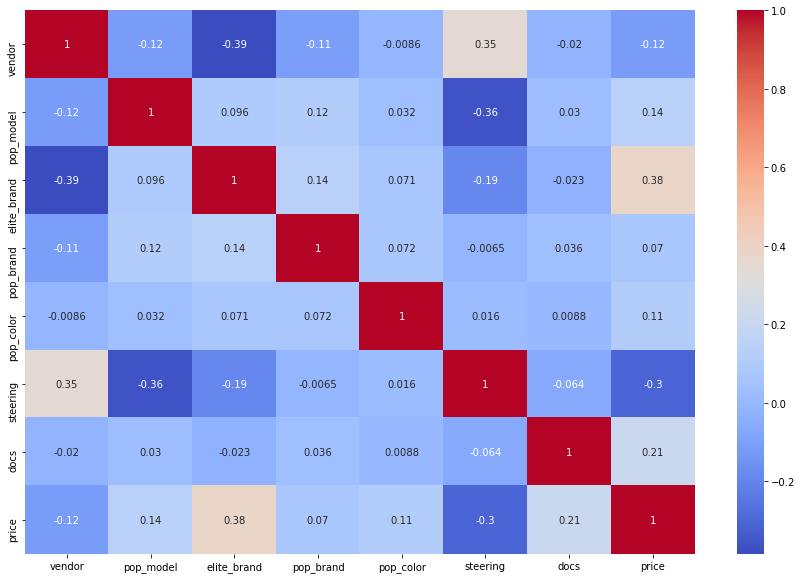

In [71]:
# Построим матрицу корреляций для бинарных признаков:

sns.heatmap(df[bin_cols+['price']].corr(), annot=True, cmap='coolwarm')

In [72]:
# Видно что сильно скоррелированных признаков нет.

<AxesSubplot:>

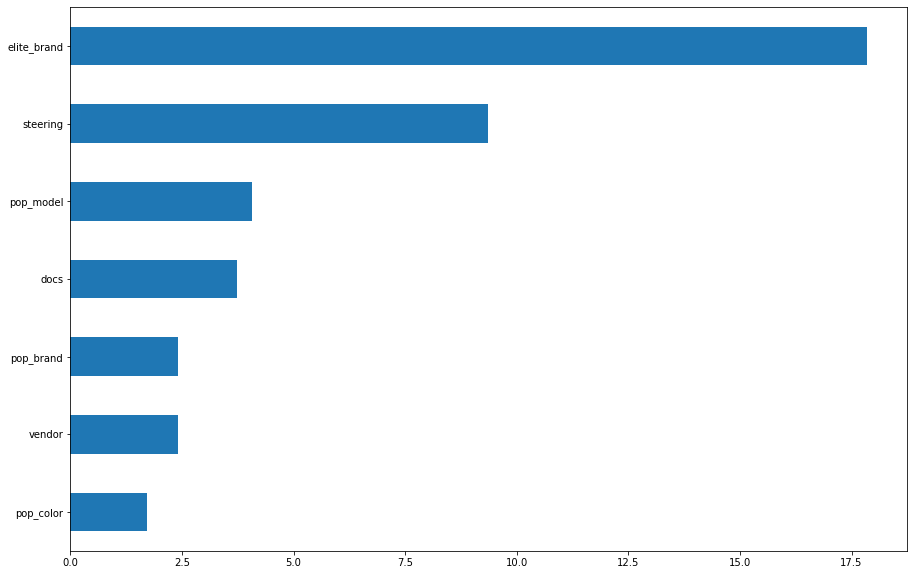

In [73]:
# Проверим значимость бинарных переменных:

imp_bin = pd.Series(f_classif(df[df.test == 0][bin_cols], 
                              df[df.test == 0].price)[0], index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

In [74]:
# Незначимых бинарных переменных нет, значит оставляем все. Как и предполагалось, сильно 
# значимым (максимум среди бинарных!) оказался сгенерированный признак элитности авто.

### 3.3 Категориальные переменные

In [75]:
# Составим список категориальных переменных:

cat_cols = ['drive', 'owners_count', 'doors_num', 'transmission',
            'fuel_type', 'rarity', 'body_type', 'color', 'brand']

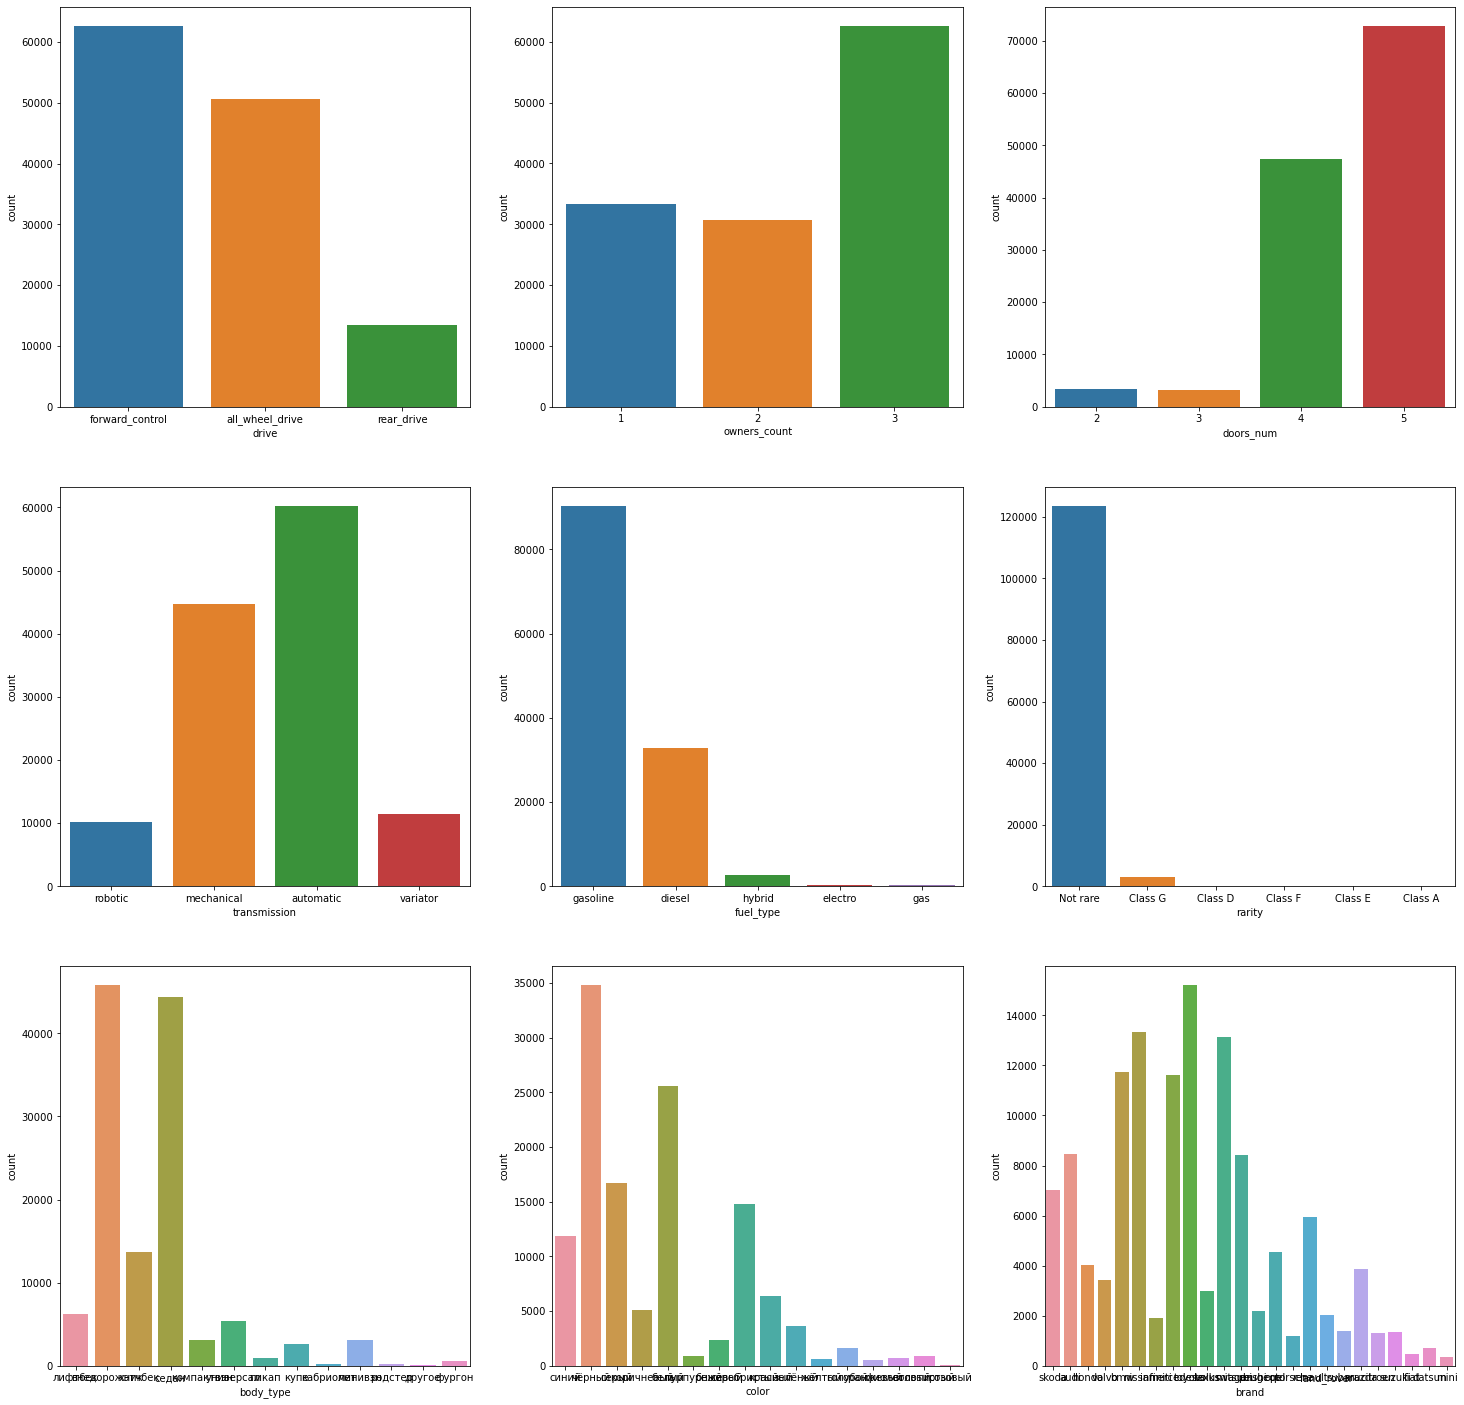

In [76]:
# Посмотрим на графики распределения категориальных переменных в зависимости от их количества:

fig, axes = plt.subplots(3, 3, figsize=(25, 25))
for col, i in zip(cat_cols, range(9)):
    sns.countplot(x=col, data=df, ax=axes.flat[i])

In [77]:
# По графикам видно что признак rarity все-таки стоит перевести в бинарный:

df.rarity = df.rarity.apply(lambda x: 0 if x == 'Not rare' else 1)

cat_cols.remove('rarity')
bin_cols.append('rarity')

In [78]:
# Перекодируем категориальные переменные:

for colum in cat_cols:
    df[colum] = df[colum].astype('category').cat.codes

<AxesSubplot:>

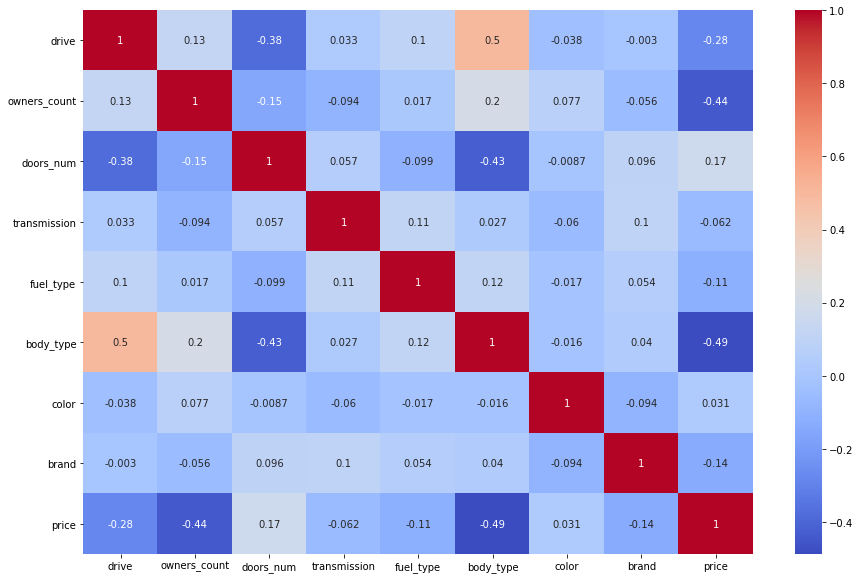

In [79]:
# Построим матрицу корреляций для категориальных признаков:

plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(df[cat_cols+['price']].corr(), annot=True, cmap='coolwarm')

In [80]:
# Сильнее всего скоррелированы признаки body_type и drive. Это легко объяснить, т.к. 
# у бОльшей части внедорожников полный привод, а внедорожник это самый популярный тип
# кузова в датасете. То-же самое и с body_type|doors_num, у большинства внедорожников
# 5 дверей, у седанов 4, а у купе, кабриолетов и родстеров 2.

<AxesSubplot:>

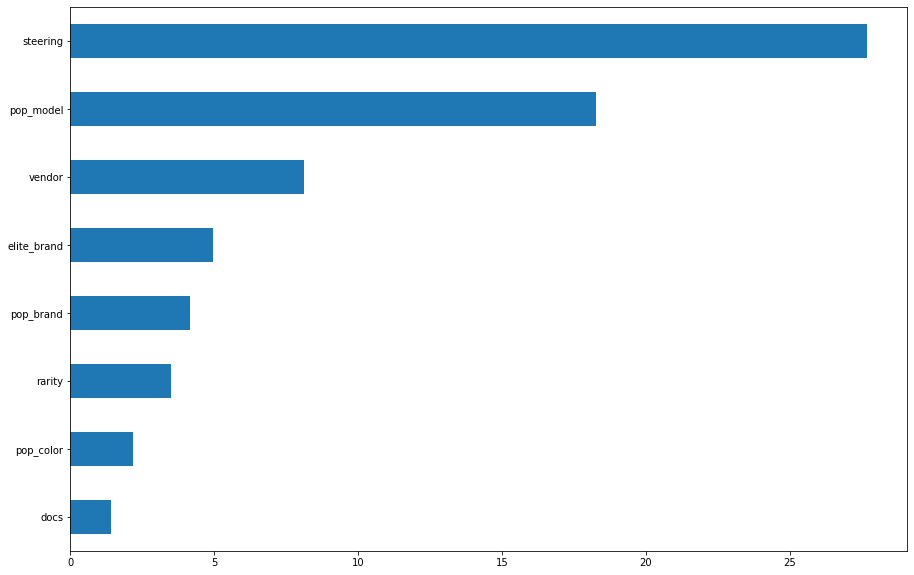

In [81]:
# Проверим значимость категориальных переменных:

imp_bin = pd.Series(f_classif(df[df.test == 0][cat_cols], 
                              df[df.test == 0].price)[0], index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

In [82]:
# Наиболее значимо расположение руля (видимо сказывается обилие дешевых б/у праворульных японцев)
# и популярность модели. Совсем незначимых переменных нет, так-что оставляем все.

### 3.4 Оставшиеся переменные

In [83]:
# Посмотрим какие признаки мы еще не просмотрели:

all_cols = list(df.columns)

for col in num_cols:
    all_cols.remove(col)

for col in bin_cols:
    all_cols.remove(col)
    
for col in cat_cols:
    all_cols.remove(col)
    
display(all_cols)

['description', 'equipment', 'model_name', 'price', 'test']

In [84]:
# Не считая целевой переменной и признака тестового датасета у нас осталось 3 переменных.

#### 3.4.1 model_name

In [85]:
# model_name это категориальный признак с очень большим количеством значений.
# Я не смог придумать что с ним сделать (кроме добавления нового признака pop_model),
# так-что просто перекодируем его:

df.model_name = df.model_name.astype('category').cat.codes

#### 3.4.2 description

In [86]:
# Посмотрим что представляет из себя признак description:

df.description.sample(10)

95209    Для Вашего комфорта, перед осмотром автомобиля...
77977    Возможность приобрести АВТОМОБИЛЬ в КРЕДИТ со ...
22195    Автомобиль в хорошем состоянии. ТО и ремонты в...
94697    Куплен у офицального дилера!Сделанно полное ТО...
42744    Ваш выбор и Ваше время — наши главные приорите...
25296    Авто в отличном техническом состоянии. Произве...
51976    Открываем месяц ярко!\n\n9 сентября ночь прода...
31911    Имеется двухзнонный климат- контроль,люк,кожа,...
39134    Автомобиль технически исправен. Устранена течь...
66649    Продам Автомобиль! Именно Автомобиль, а не маш...
Name: description, dtype: object

In [87]:
# Для начала уберем из текста все \n :

df.description = df.description.apply(lambda x: x.replace('\n', ''))

In [88]:
# Сначала я хотел просто посчитать количество слов в описании, потом решил
# дополнительно посчитать еще количество цифр, а так-же НЕ цифр и НЕ букв.
# Потом можно будет проверить какие из новых признаков будут влиять цену.

# Функция для подсчета цифр в строке: 
def count_digit(description):
    digits = 0
    for elem in re.findall(r'\d+', description):
        digits += len(elem)
    return digits

# Функция для подсчета не-букв и не-цифр в строке:
def count_symbols(description):
    symbols = 0
    for elem in re.findall(r'\W+', description):
        symbols += len(elem)
    return symbols

In [89]:
# Сгенерируем 2 новые переменные:

df['desc_digits'] = df.description.apply(count_digit)

df['desc_symbols'] = df.description.apply(count_symbols)

In [90]:
# Посчитаем так-же число слов в описании и общую длину описания:

df['desc_words'] = df.description.apply(lambda x: len(x.split(' ')))

df['desc_len'] = df.description.apply(lambda x: len(x))

<AxesSubplot:>

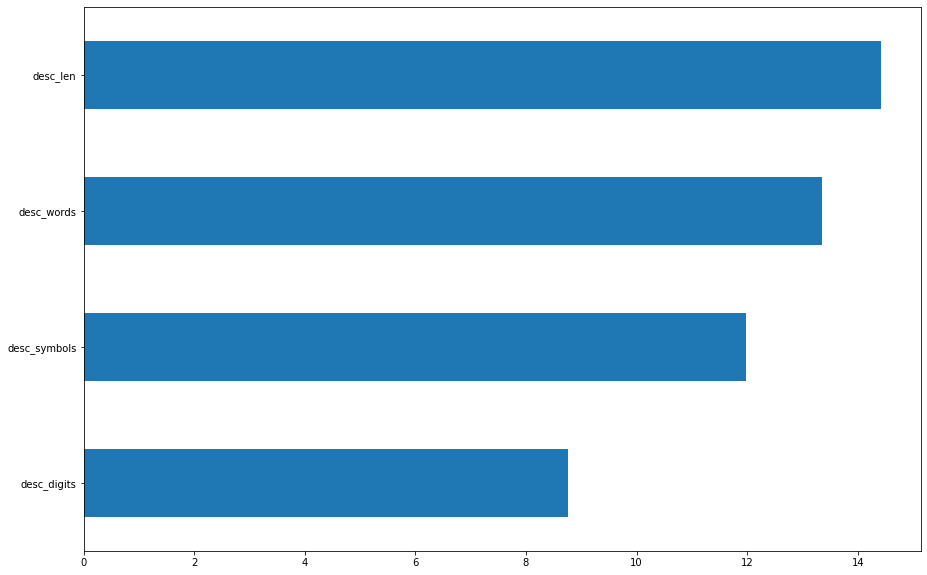

In [91]:
# Проверим значимость сгенерированных переменных:

desc_cols = ['desc_digits', 'desc_symbols', 'desc_words', 'desc_len']

imp_bin = pd.Series(f_classif(df[df.test == 0][desc_cols], 
                              df[df.test == 0].price)[0], index=desc_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

<AxesSubplot:>

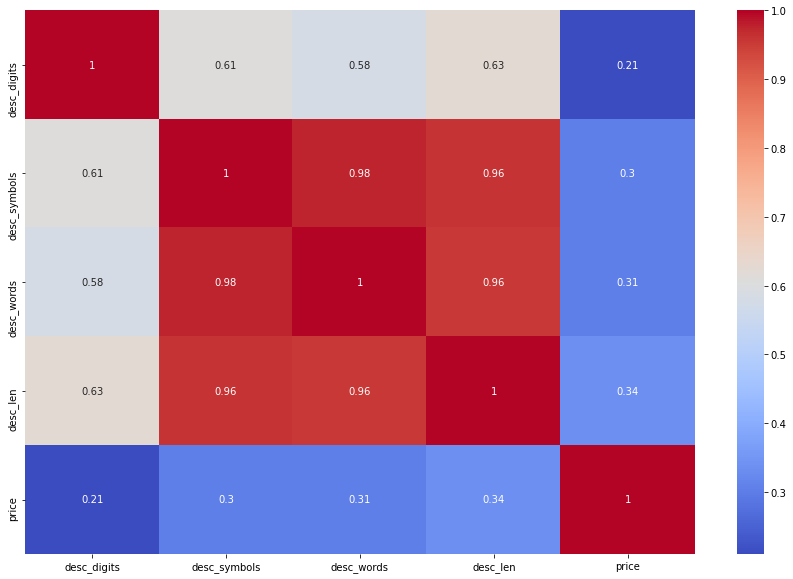

In [92]:
# Проверим так-же их корреляцию:

plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(df[desc_cols+['price']].corr(), annot=True, cmap='coolwarm')

In [93]:
# Вполне ожидаемо что сгенерированные признаки очень сильно скоррелированы между собой.
# Оставим только признак desc_len (как наиболее значимый для модели) и признак 
# desc_digits (который скоррелирован с остальными меньше всех, но все-равно 
# значим для модели):

df.drop(columns=['desc_symbols', 'desc_words'], inplace=True)

In [94]:
# Так-же удалим сам столбец с описаниями:

df.drop(columns=['description'], inplace=True)

#### 3.4.2 equipment

In [95]:
# Посмотрим что представляет из себя признак equipment:

df.equipment.sample(10)

96812                                                    {}
114756                                                   {}
16247     {"cruise-control":true,"tinted-glass":true,"ro...
61017     {'cruise-control': True, 'asr': True, 'esp': T...
99813     {'asr': True, 'esp': True, 'multi-wheel': True...
69890     {'tinted-glass': True, 'aux': True, 'usb': Tru...
103501    {'cruise-control': True, 'esp': True, 'airbag-...
16883     {"cruise-control":true,"tinted-glass":true,"es...
20442     {"engine-proof":true,"airbag-driver":true,"air...
78186     {'airbag-driver': True, 'isofix': True, 'aux':...
Name: equipment, dtype: object

In [96]:
# По сути equipment это словарь, только в виде строки и с некоторыми
# "проблемами". Исправим их перед конвертацией:

df.equipment = df.equipment.apply(lambda x: x.replace('"', '\''))

df.equipment = df.equipment.apply(lambda x: x.replace(':true', ': True'))

In [97]:
# Теперь сконвертируем строки в словари:

def eqp_to_dict(equipment):
    try:
        return eval(equipment)
    except:
        return {}
    
df.equipment = df.equipment.apply(eqp_to_dict)

In [98]:
# Теперь с признаком можно работать. Первое (и самое очевидное), что можно  из него
# получить это количество опций для каждого автомобиля. Сохраним его в новый признак:

df['options_count'] = df.equipment.apply(lambda x: len(x))

In [99]:
# Далее, т.к. все словари по сути являются списком опций (опции это ключи, а все значения
# всегда True), можно превратить equipment в список:

df.equipment = df.equipment.apply(lambda x: list(x.keys()))

In [100]:
# Теперь посмотрим сколько всего опций нашем в датасете:

optinons_list = df.equipment.explode().value_counts()

display(optinons_list)

lock               73384
abs                73177
electro-mirrors    67622
computer           62550
immo               60576
                   ...  
4A3                    1
KA2                    1
4R3                    1
L5C                    1
810                    1
Name: equipment, Length: 291, dtype: int64

In [101]:
# 291 различная опция, среди которых многие встречаются по 1 разу. Для обработки это
# слишком много. Оставим 15 самых популярных опций, остальные сохраним в спиок "непопулярных":

not_pop_options = []

for i in range(len(optinons_list)):
    if optinons_list[i] < optinons_list[15]:
        not_pop_options.append(optinons_list.index[i])

In [102]:
# Теперь все редкие опции заменяем на 'other'. Если в одном списке будет несколько таких опций,
# то сохраняем только первую (т.к. кол-во опций мы уже сохранили в отдельный признак):

def replace_options(options):
    for i in range(len(options)):
        if options[i] in not_pop_options:
            options[i] = 'other'
    return list(set(options))

df.equipment = df.equipment.apply(replace_options)

In [103]:
# Теперь из списка опций создадим dummies-переменные:

dummies_equipment = pd.get_dummies(
    df.equipment.apply(pd.Series).stack()).sum(level=0)

In [104]:
# Присоединяем dummies с опциями к основному датасету:

df = pd.concat([df, dummies_equipment], axis=1)

In [105]:
# И удаляем ненужный более столбец equipment:

df.drop(['equipment'], axis = 1, inplace=True)

In [106]:
# В списке опций были пустые строки из-за чего в нашем датасете появились пропуски.
# Заполним их все нулями:
df = df.fillna(0)

## 4. Проверяем что получилось

Проверяем получившийся датасет перед сохранением.

In [107]:
# Посмотрим на получившийся датасет:

print('Размер итогового датасета: ', df.shape)
display(df.sample(5))

Размер итогового датасета:  (126689, 45)


,body_type,brand,color,engine_volume,engine_power,fuel_type,mileage,model_name,doors_num,production_date,transmission,vendor,owners_count,docs,drive,steering,price,test,pop_color,pop_brand,elite_brand,pop_model,prod_annot,km_year,rarity,desc_digits,desc_len,options_count,abs,airbag-driver,airbag-passenger,aux,computer,electro-mirrors,electro-window-back,electro-window-front,esp,front-seats-heat,immo,lock,mirrors-heat,other,ptf,usb,wheel-leather
46491,0,13,11,2.0,141,3,179000,655,3,2012,3,1,2,1,0,0,13.946539,0,1,1,0,1,2,19889,0,1,308,21,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
117363,9,9,11,2.3,175,3,211000,71,2,2004,1,1,2,1,1,0,12.611538,0,1,0,0,1,2,12412,0,6,218,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111060,12,10,1,2.7,170,0,318000,195,1,2002,2,0,2,1,2,0,12.821258,0,1,1,1,1,2,16737,0,0,115,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
38972,6,10,11,2.0,163,0,207000,848,3,2014,0,0,2,1,0,0,14.841552,0,1,1,1,1,0,29571,0,23,1674,36,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
35444,12,0,1,1.2,105,3,173000,100,3,2014,1,0,2,1,1,0,13.955273,0,1,1,1,1,2,24714,0,4,332,50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [108]:
display(df.info())
display(df.nunique().sort_values())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126689 entries, 0 to 126688
Data columns (total 45 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             126689 non-null  int8   
 1   brand                 126689 non-null  int8   
 2   color                 126689 non-null  int8   
 3   engine_volume         126689 non-null  float64
 4   engine_power          126689 non-null  int64  
 5   fuel_type             126689 non-null  int8   
 6   mileage               126689 non-null  int64  
 7   model_name            126689 non-null  int16  
 8   doors_num             126689 non-null  int8   
 9   production_date       126689 non-null  int64  
 10  transmission          126689 non-null  int8   
 11  vendor                126689 non-null  int64  
 12  owners_count          126689 non-null  int8   
 13  docs                  126689 non-null  int64  
 14  drive                 126689 non-null  int8   
 15  

None

wheel-leather               2
abs                         2
aux                         2
computer                    2
electro-mirrors             2
rarity                      2
electro-window-back         2
usb                         2
pop_model                   2
elite_brand                 2
pop_brand                   2
pop_color                   2
test                        2
electro-window-front        2
airbag-driver               2
steering                    2
docs                        2
vendor                      2
esp                         2
front-seats-heat            2
immo                        2
lock                        2
mirrors-heat                2
other                       2
ptf                         2
airbag-passenger            2
owners_count                3
drive                       3
transmission                4
doors_num                   4
fuel_type                   5
body_type                  13
color                      16
prod_annot

In [109]:
# Упс! Случайно заполнил цены в тестовом датасете нулями. Нестрашно, т.к. при разделении 
# датасета обратно на тестовый и тренировочный из тестовго датасета price все-равно 
# будет удален.

<AxesSubplot:>

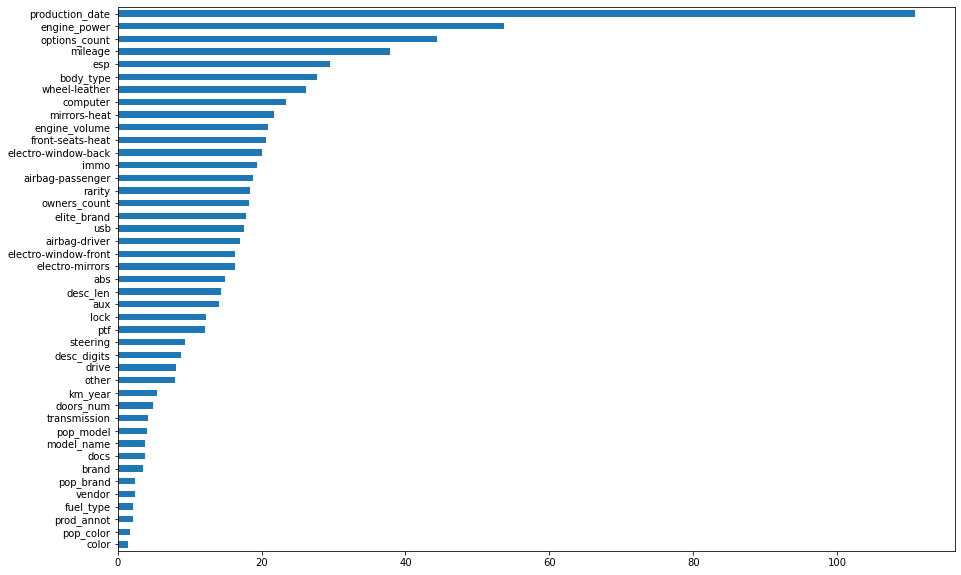

In [110]:
# Проверим значимость всех переменных сразу:

all_cols = list(df.columns)

all_cols.remove('price')
all_cols.remove('test')

imp_bin = pd.Series(f_classif(df[df.test == 0][all_cols], 
                              df[df.test == 0].price)[0], index=all_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

<AxesSubplot:>

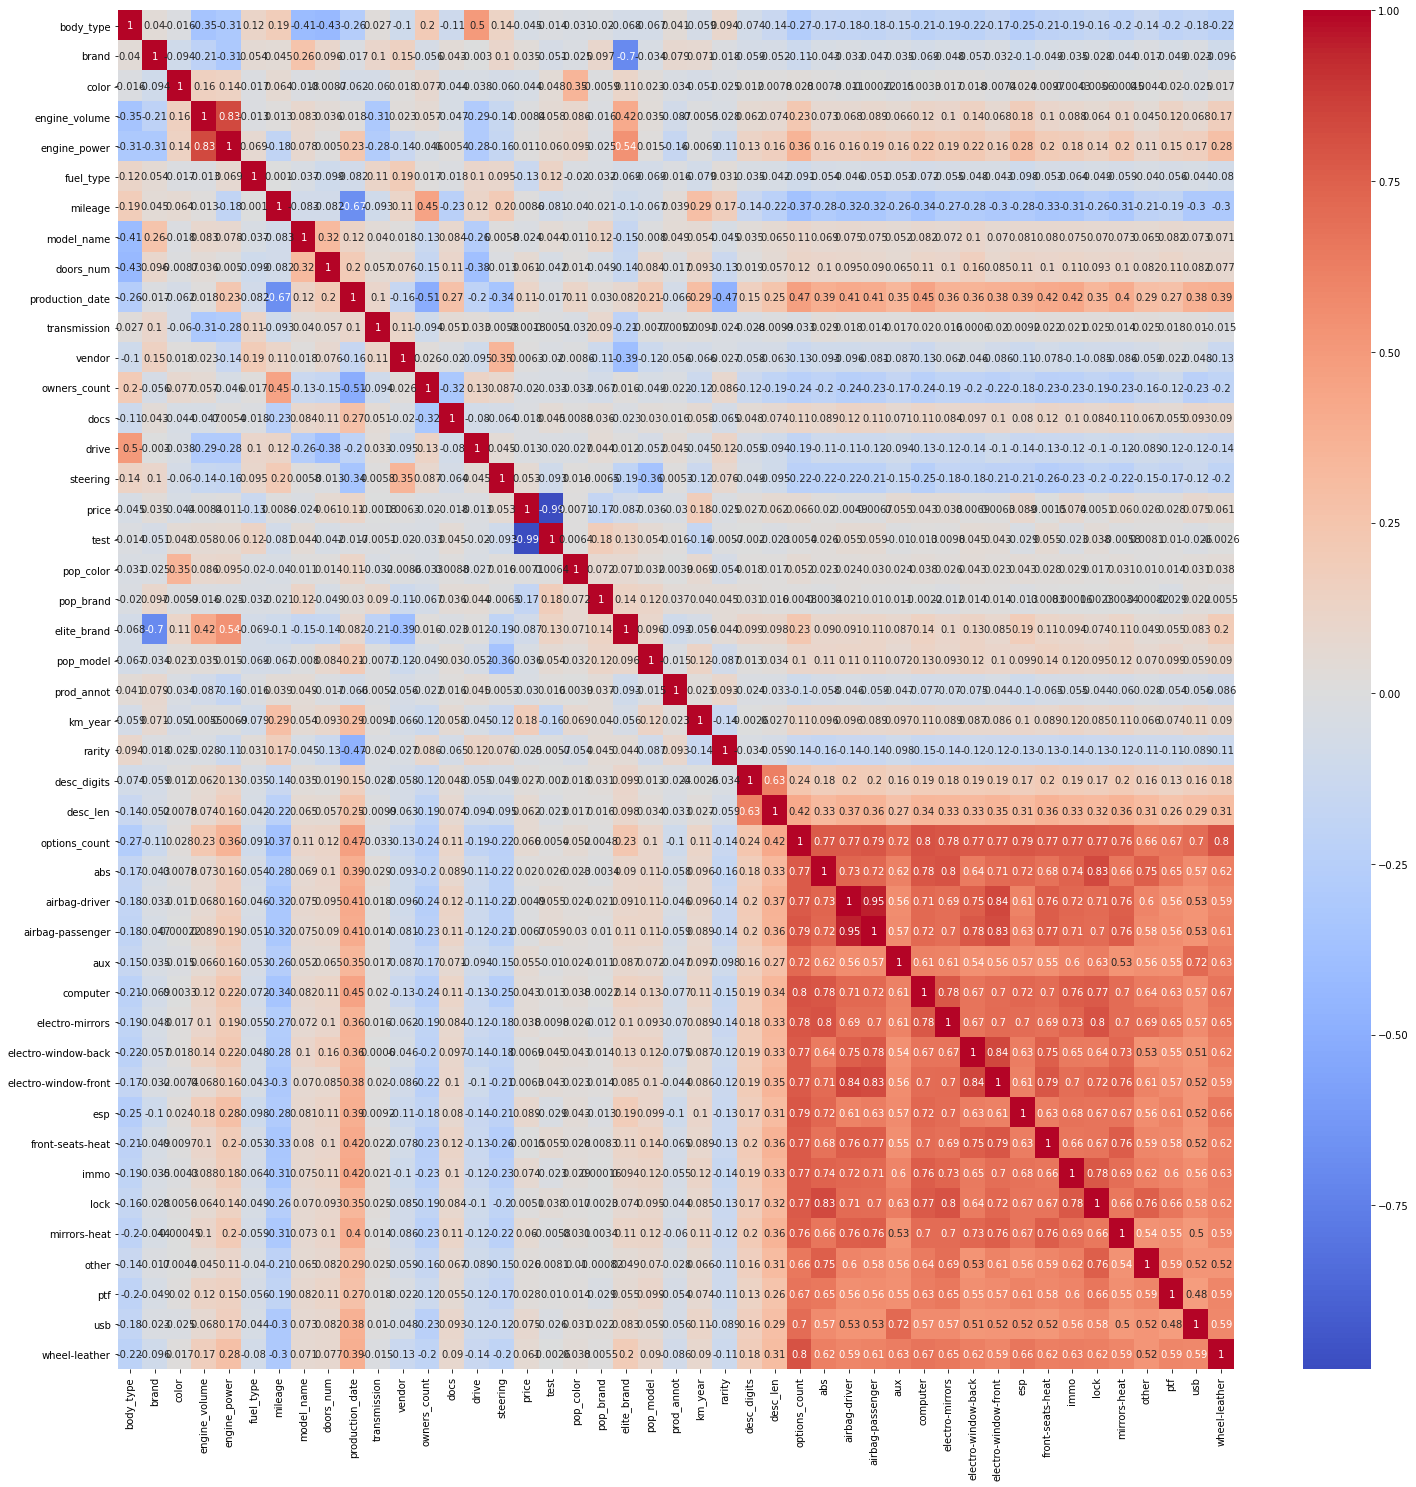

In [111]:
# Проверим так-же их корреляцию:

plt.rcParams['figure.figsize'] = 25, 25
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [112]:
# Незначимых признаков в нашем датасете нет. dummies-переменные достаточно сильно 
# скоррелированы между собой (неудивительно, все-таки это самые популярные опции).
# Среди опций из каждой сильно скоррелированной пары (корреляция 0.8 и больше) удалим 
# менее значимую. Помимо них сильно скоррелированы engine_volume и engine_power, из 
# них так-же удалим менее значимый признак. Составим список колонок на удаление:

cols_for_remove = ['engine_volume', 'airbag-driver', 'computer',
                   'electro-window-front', 'lock', 'abs', 'wheel-leather']

df.drop(columns = cols_for_remove, axis = 1, inplace=True)

In [118]:
# ВНИМАНИЕ!!! КОД НИЖЕ ЗАКОММЕНТИРОВАН, ЧТО-БЫ НЕ ПЕРЕЗАПИСЫВАТЬ ФАЙЛ КАЖДЫЙ РАЗ!!!

# Теперь наш датасет подготовлен для моделирования, сохраняем его:

#df.to_csv(PATH_to_file + 'df_prepared.csv', index=False)

## 5. Выводы

   После обработки тестового и тренировочных датасетов подготовлен датасет для обучения моделей.
    
   Сгенерированы новые признаки (популярность цвета/модели/бренда, признаки на основе описания автомобиля и т.д.), удалено несколько имевшихся признаков (описание, комплектация, объем двигателя и т.д.).
   
   В подготовленном датасете отсутствуют пропуски, все переменные перекодированы числами.
   
   На основе времени парсинга объявлений впоследсвии можно будет провести корректировку получившихся предсказаний (как минимум по разнице курса доллара, м.быть по еще каким-то параметрам).
   
   Целевая переменная логарифмирована для нормализации распределения, после построения модели и получения предсказаний надо не забыть проэкспонировать результат.
   
   Получившийся датасет сохранен в отдельный файл, теперь можно приступать к обучению моделей. 
   